In [155]:
# Importing modules
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score, f1_score
# read data
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load the cleaned data with DEP_DELAY included
# df_cleaned = pd.read_csv("../cleaning-preprocessing/cleaned_flight_data_with_target.csv")
df_cleaned = pd.read_csv("../cleaning-preprocessing/regression_cleaned_flight_data_with_target.csv")
non_negative_df_cleaned = df_cleaned
negative_df_cleaned = df_cleaned[df_cleaned['DEP_DELAY'] <= 0]


#Separating Features
X_train, X_test, Y_train, Y_test = train_test_split(non_negative_df_cleaned.drop(columns=['DEP_DELAY']), non_negative_df_cleaned['DEP_DELAY'], test_size=0.2, random_state=43)

X_Train_neg, X_Test_neg, Y_Train_neg, Y_Test_neg = train_test_split(negative_df_cleaned.drop(columns=['DEP_DELAY']), negative_df_cleaned['DEP_DELAY'], test_size=0.2, random_state=43)

In [157]:
# Find the minimum value across both train and test sets
min_y = min(Y_train.min(), Y_test.min())

# Shift by adding abs(min_y) + 1 (to ensure all values are positive)
Y_shift = abs(min_y) + 1

# Apply log transformation
Y_train_log = np.log(Y_train + Y_shift)
Y_test_log = np.log(Y_test + Y_shift)

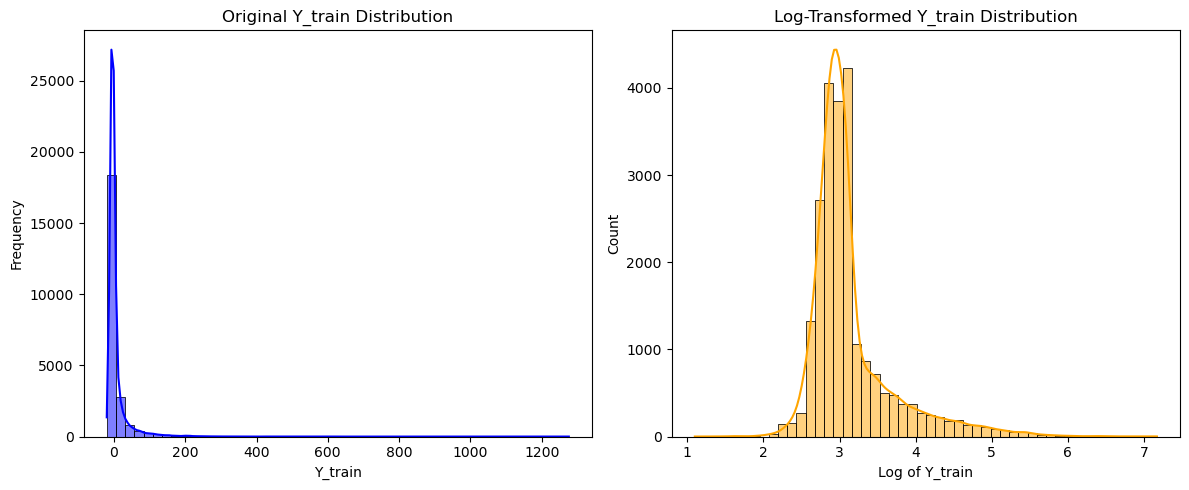

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Y_train distribution
sns.histplot(Y_train, bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Original Y_train Distribution")
axes[0].set_xlabel("Y_train")
axes[0].set_ylabel("Frequency")

# Log-transformed Y_train distribution
sns.histplot(Y_train_log, bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title("Log-Transformed Y_train Distribution")
axes[1].set_xlabel("Log of Y_train")

plt.tight_layout()
plt.show()


### Train a Base-Model

In [159]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Train the model
base_model = XGBRegressor(random_state=42)
base_model.fit(X_train, Y_train_log)

# Predict in log scale
predictions_log = base_model.predict(X_test)

# Convert predictions and Y_test back to original scale
predictions_original = np.exp(predictions_log) - Y_shift

# Compute all metrics on the original scale
mae_original = mean_absolute_error(Y_test, predictions_original)
mse_original = mean_squared_error(Y_test, predictions_original)
rmse_original = np.sqrt(mse_original)

# Print results
print(f"Mean Absolute Error (MAE): {mae_original:.4f}")
print(f"Mean Squared Error (MSE): {mse_original:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_original:.4f}")




Mean Absolute Error (MAE): 10.5566
Mean Squared Error (MSE): 866.3053
Root Mean Squared Error (RMSE): 29.4331


/var/folders/8r/dzqq2n5966qg19z5gyr4drh00000gn/T/ipykernel_4306/1965860066.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_10_features, palette='viridis')


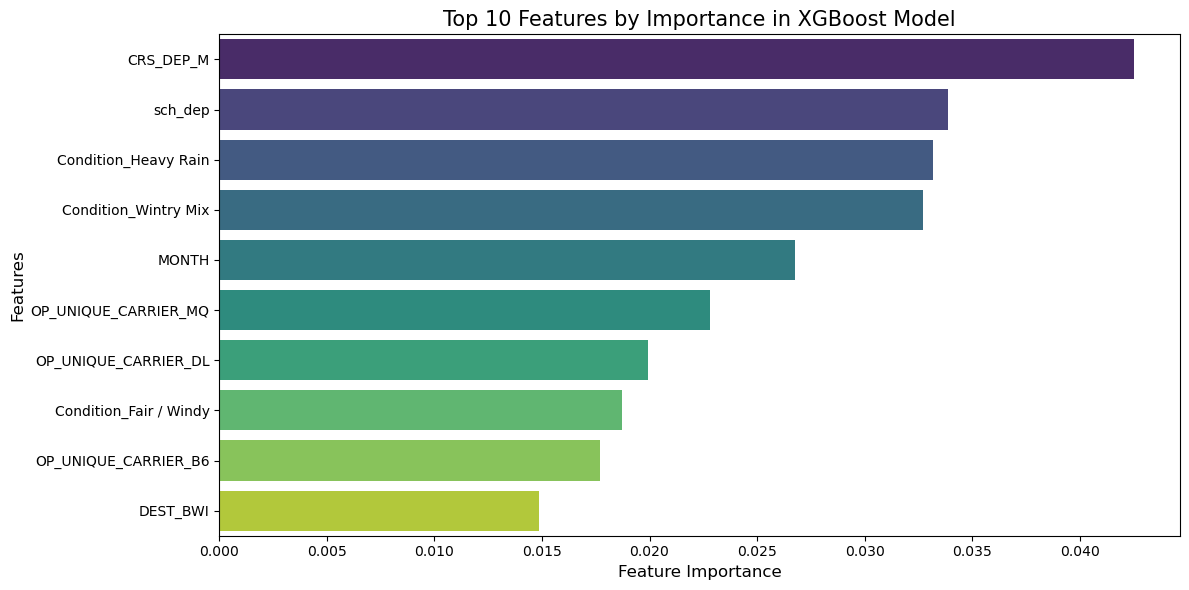

                    feature  importance
5                 CRS_DEP_M    0.042532
13                  sch_dep    0.033885
92     Condition_Heavy Rain    0.033183
108    Condition_Wintry Mix    0.032724
0                     MONTH    0.026763
19     OP_UNIQUE_CARRIER_MQ    0.022814
17     OP_UNIQUE_CARRIER_DL    0.019919
89   Condition_Fair / Windy    0.018731
16     OP_UNIQUE_CARRIER_B6    0.017700
30                 DEST_BWI    0.014871


In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importance = base_model.feature_importances_

# Create a DataFrame of features and their importance
features_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
})

# Sort features by importance in descending order and select top 10
top_10_features = features_df.sort_values('importance', ascending=False).head(10)

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features by Importance in XGBoost Model', fontsize=15)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Print out the exact importance values for reference
print(top_10_features)

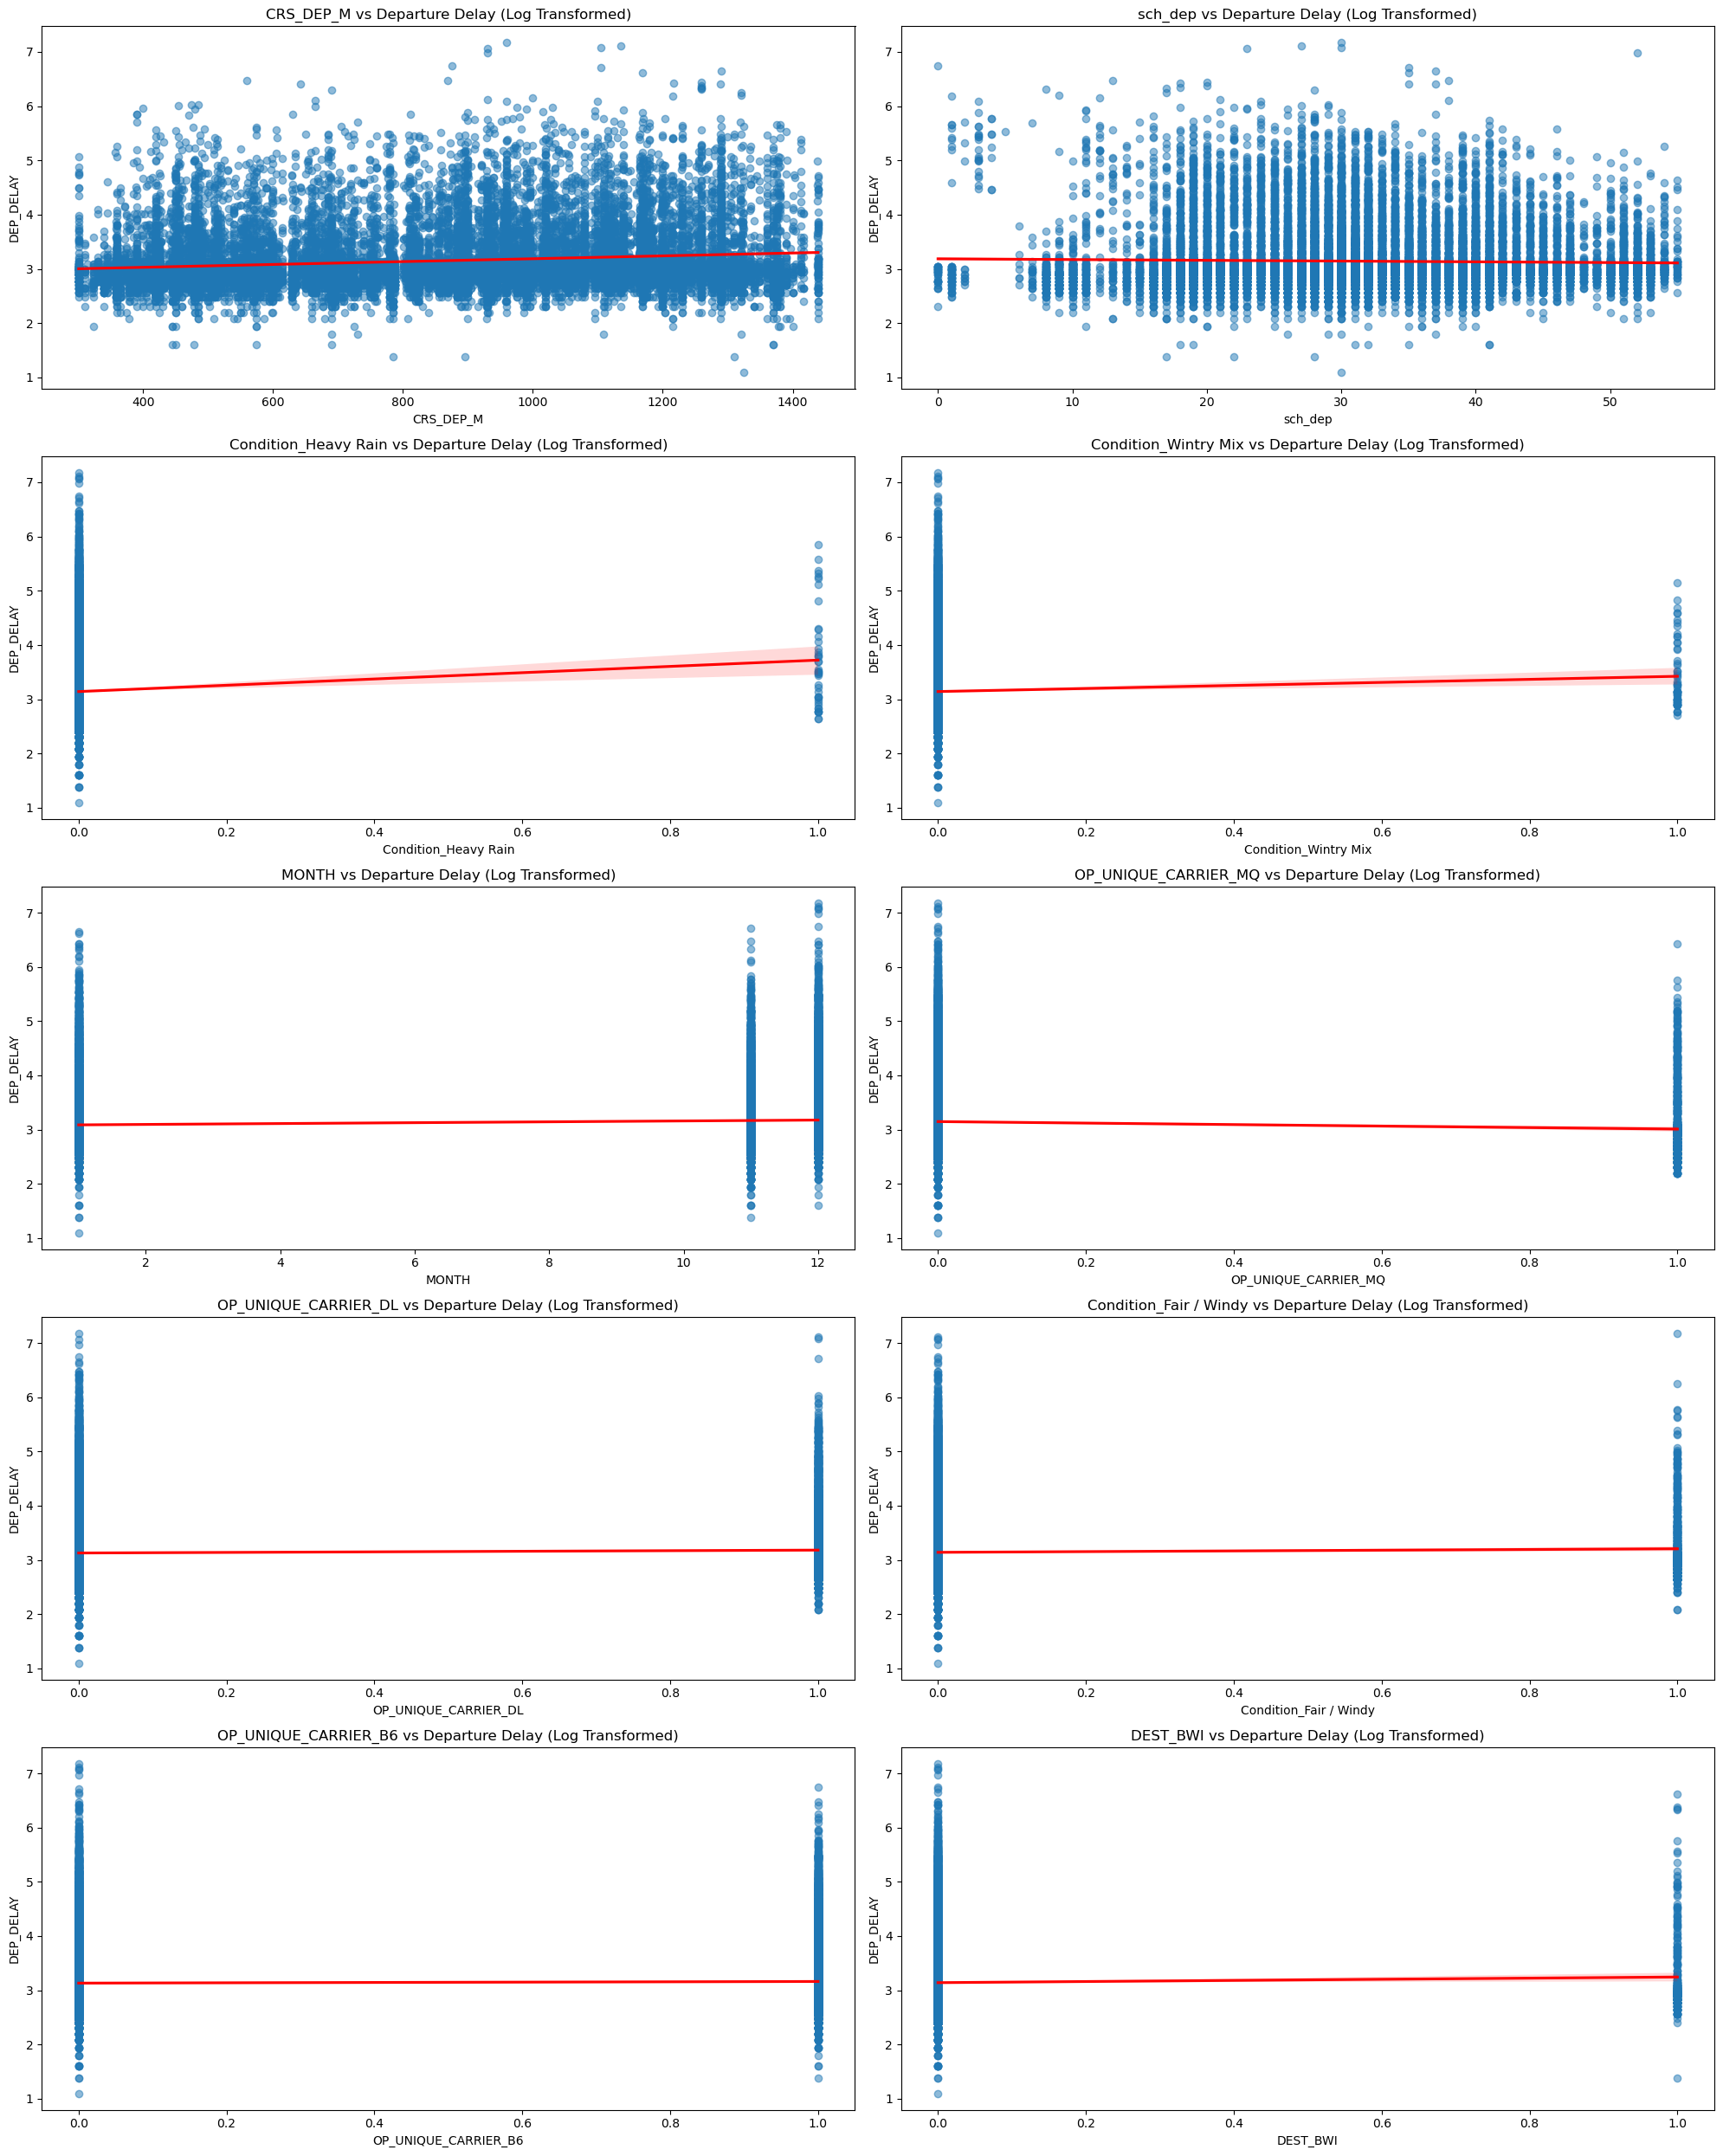

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances and identify top 10 features
feature_importance = base_model.feature_importances_
features_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
})
top_10_features = features_df.sort_values('importance', ascending=False).head(10)

# Create a 5x2 grid of subplots for the top 10 features
plt.figure(figsize=(20, 25))

for i, feature in enumerate(top_10_features['feature'], 1):
    plt.subplot(5, 2, i)
    
    # Create scatter plot
    plt.scatter(X_train[feature], Y_train_log, alpha=0.5)
    
    # Add title and labels
    plt.title(f'{feature} vs Departure Delay (Log Transformed)', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Log Transformed Departure Delay', fontsize=10)
    
    # Optional: Add a trend line
    sns.regplot(x=X_train[feature], y=Y_train_log, scatter=False, color='red')

plt.tight_layout()
plt.show()

In [162]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': base_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Define importance threshold
threshold = 0.01

# Select important features
selected_features_threshold = feature_importance[feature_importance["Importance"] > threshold]["Feature"].tolist()

print("Selected Features:", selected_features_threshold)

# Filter dataset
X_train_selected_threshold = X_train[selected_features_threshold]
X_test_selected_threshold = X_test[selected_features_threshold]

Selected Features: ['CRS_DEP_M', 'sch_dep', 'Condition_Heavy Rain', 'Condition_Wintry Mix', 'MONTH', 'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_DL', 'Condition_Fair / Windy', 'OP_UNIQUE_CARRIER_B6', 'DEST_BWI', 'Pressure', 'DEST_LAX', 'Wind Speed', 'DISTANCE', 'DEST_CMH', 'OP_UNIQUE_CARRIER_OO', 'DEST_RIC', 'DEST_OAK', 'DEST_IAH', 'DEST_FLL', 'Wind Gust', 'Temperature', 'Dew Point', 'Condition_Rain', 'DAY_OF_WEEK', 'DEST_BOS', 'DAY_OF_MONTH', 'DEST_BTV', 'DEST_IND', 'DEST_SJC', 'Condition_Heavy Rain / Windy', 'Condition_Light Drizzle', 'Humidity', 'CRS_ARR_M', 'Condition_Light Snow / Windy', 'Condition_Mostly Cloudy']


In [163]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': np.arange(5,30,5),
    'n_estimators': np.arange(50,210,50),
    'learning_rate': np.arange(0.01,0.31,0.1)
}

grid_search_threshold = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), params, scoring='neg_mean_absolute_error', cv=3, verbose=2)
grid_search_threshold.fit(X_train_selected_threshold, Y_train_log)

print(grid_search_threshold.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   5.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

In [ ]:
params = {
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# RandomizedSearchCV with 100 iterations
random_search_threshold = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                                   param_distributions=params, n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search_threshold.fit(X_train_selected_threshold, y_train)

print("Best Parameters:", random_search_threshold.best_params_)

In [165]:
print(grid_search_threshold.best_params_)
best_model = XGBRegressor(**grid_search_threshold.best_params_, objective='reg:squarederror', random_state=42)
best_model.fit(X_train_selected_threshold, Y_train_log)
predictions_log = best_model.predict(X_test_selected_threshold)
predictions = np.exp(predictions_log) - Y_shift

# Compute metrics
mae = mean_absolute_error(Y_test, predictions)
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)


# Print performance metrics
print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


{'learning_rate': 0.21000000000000002, 'max_depth': 5, 'n_estimators': 200}

Model Performance Metrics:
Mean Absolute Error: 10.202775229024523
Mean Squared Error: 854.8288469045846
Root Mean Squared Error: 29.2374562317686
